##### Imports

In [217]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Data Imports

In [218]:
train = pd.read_excel('../Data/historical.xlsx')
test= pd.read_excel('../Data/predict.xlsx')

train.set_index('CustomerID', inplace = True)
test.set_index('CustomerID', inplace = True)

## Initial Feature Engineering

In [219]:
for df in [train, test]:
# Gender creation
    df['Gender'] = np.where(df['Name'].str.contains('Mr.'), 'M', 'F')

# Antiquity creation
    df[df.Date_Adherence.apply(lambda x: isinstance(x, str))]                                         #16 cases of string 2/29/2022
    df.loc[df.Date_Adherence.apply(lambda x: isinstance(x, str)), 'Date_Adherence'] = '3/01/2022'     # Converted to 3/01/2022 and to datetime object
    df['Date_Adherence'] = pd.to_datetime(df['Date_Adherence'])
    df['Antiquity'] = (datetime.today() - df['Date_Adherence']).dt.days
    df['Antiquity'] = df['Antiquity'].astype(int)

# Age creation
    df['Age'] = datetime.now().year - df.Birthyear
    df['Age'] = df['Age'].astype(int)

#Freq creation
    df['Freq'] = df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumOfferPurchases']].sum(axis=1)

#Amount Total creation
    df['Mnt_Total'] = df[['MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts','MntAdditionalRequests']].sum(axis=1)

#Drop irrelevant cols
    df.drop(['Name', 'Birthyear', 'Date_Adherence'], axis=1, inplace=True)

## EDA

In [220]:
train.drop_duplicates(inplace=True)

In [221]:
numeric = train[[
    'Income', 'Recency', 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests',
    'NumOfferPurchases', 'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth', 'Antiquity', 'Age', 'Freq', 'Mnt_Total'
    ]].copy()

categorical = train[[
    'Education', 'Marital_Status', 'Kid_Younger6', 'Children_6to18', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 
    'Response_Cmp5', 'Response_Cmp1', 'Complain', 'DepVar', 'Gender'
    ]].copy()

### Categorical

In [222]:
categorical.astype('object').describe()

,Education,Marital_Status,Kid_Younger6,Children_6to18,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Response_Cmp1,Complain,DepVar,Gender
count,2468,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
unique,5,10,3,3,2,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0,0,0,M
freq,1251,1009,1463,1306,2297,2330,2303,2341,2470,2468,2187,1990


In [223]:
train.Education.value_counts()

Graduation    1251
PhD            522
Master         404
HighSchool     225
Basic           66
Name: Education, dtype: int64

In [224]:
train.Marital_Status.value_counts()

Married     1009
Together     592
Single       533
Divorced     212
Widow         82
married       37
single        15
together       9
divorced       6
widow          5
Name: Marital_Status, dtype: int64

### Numeric

In [225]:
numeric.describe()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Antiquity,Age,Freq,Mnt_Total
count,2500.00000,2452.000000,2500.000000,2500.0000,2500.00000,2479.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000
mean,77557.22760,48.983279,3071.254400,526.5824,2748.27880,545.916499,524.16320,42.555600,2.454400,5.996800,3.8524,5.828400,5.29280,678.519200,46.379200,18.132000,7454.165200
std,35505.41711,28.636798,3376.433081,761.3516,3875.42553,793.028804,763.86874,49.576031,2.300356,2.757214,3.4258,3.339134,2.71286,203.504919,11.897631,7.972854,7581.458263
min,2678.00000,0.000000,0.000000,0.0000,5.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,334.000000,18.000000,0.000000,18.000000
25%,50998.00000,25.000000,240.000000,40.0000,225.00000,40.000000,40.00000,8.000000,1.000000,4.000000,1.0000,3.000000,3.00000,503.000000,38.000000,11.000000,766.750000
50%,76684.50000,48.000000,1795.000000,180.0000,1110.00000,180.000000,180.00000,24.000000,2.000000,6.000000,3.0000,5.000000,6.00000,670.000000,45.000000,18.000000,4753.500000
75%,101712.00000,73.000000,5050.000000,680.0000,3693.75000,700.000000,680.00000,57.000000,3.000000,8.000000,5.0000,8.000000,7.00000,854.000000,56.000000,24.000000,12585.000000
max,237117.00000,99.000000,14980.000000,3980.0000,24886.00000,3960.000000,3980.00000,249.000000,16.000000,13.000000,24.0000,13.000000,20.00000,1032.000000,75.000000,42.000000,32657.000000


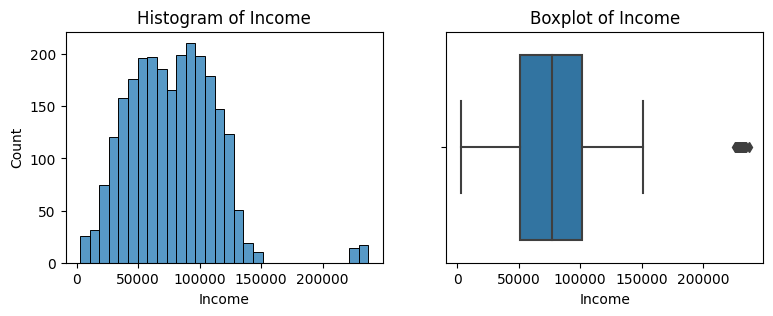

Skew: 0.8279467543830179, Kurtosis : 2.550323618111481


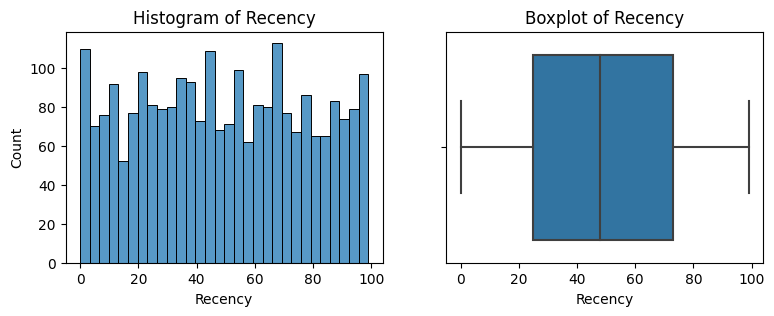

Skew: 0.028003334183665678, Kurtosis : -1.150535984763835


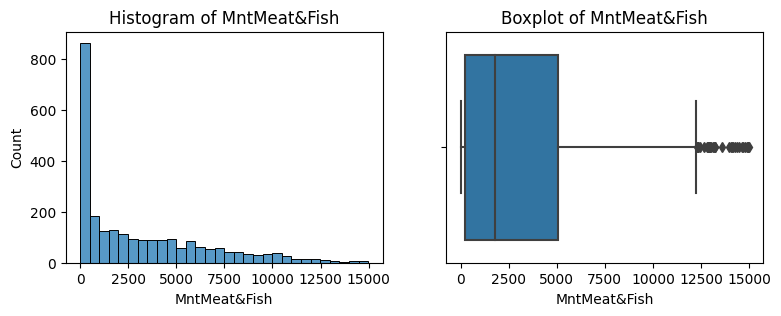

Skew: 1.135132472979566, Kurtosis : 0.4774072234927962


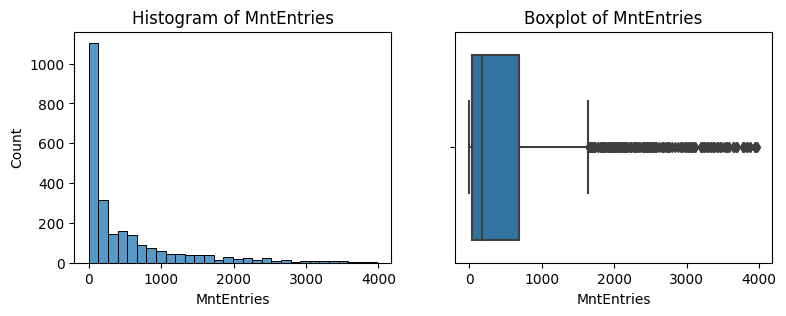

Skew: 2.091728377666883, Kurtosis : 4.292902198701057


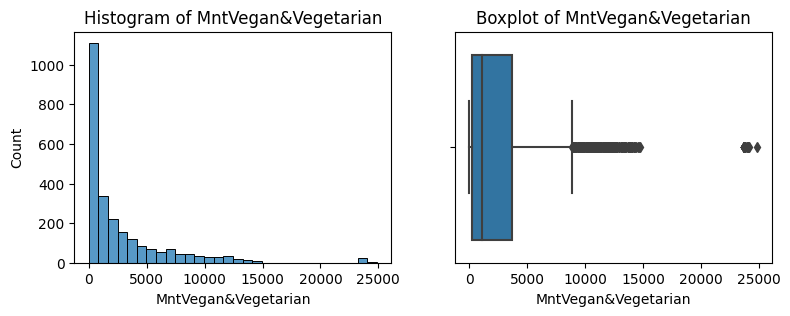

Skew: 2.4795529647990464, Kurtosis : 8.099056921985124


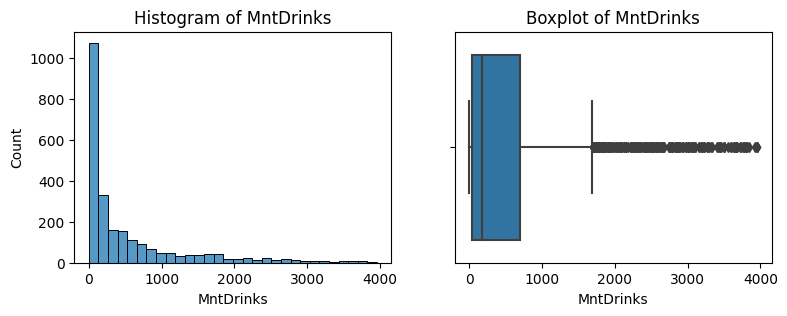

Skew: 2.01621025032237, Kurtosis : 3.7427002389973048


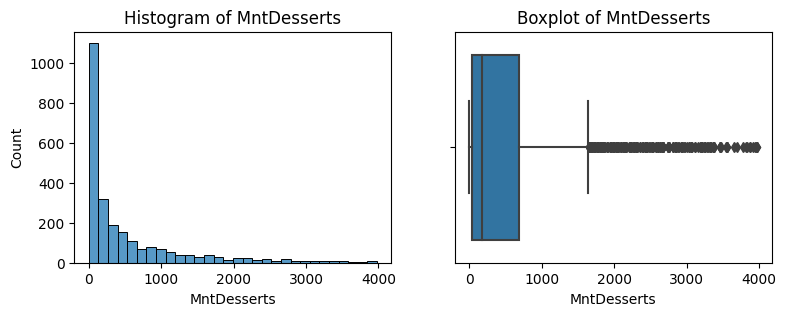

Skew: 2.071036987626397, Kurtosis : 4.0847740838963835


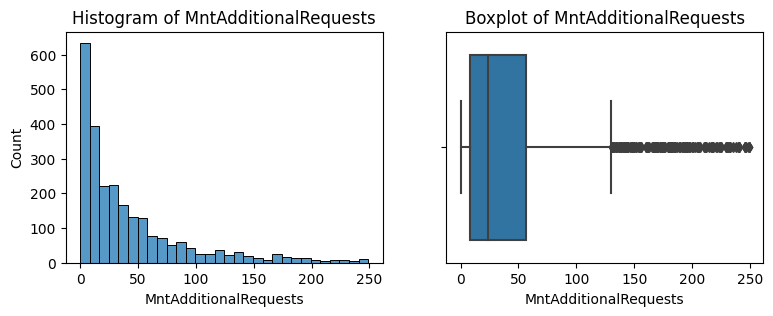

Skew: 1.8497950464594828, Kurtosis : 3.246925765909702


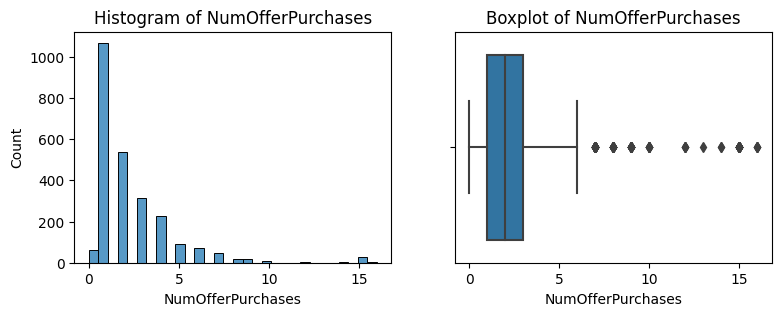

Skew: 2.8754868798433155, Kurtosis : 11.29364854186155


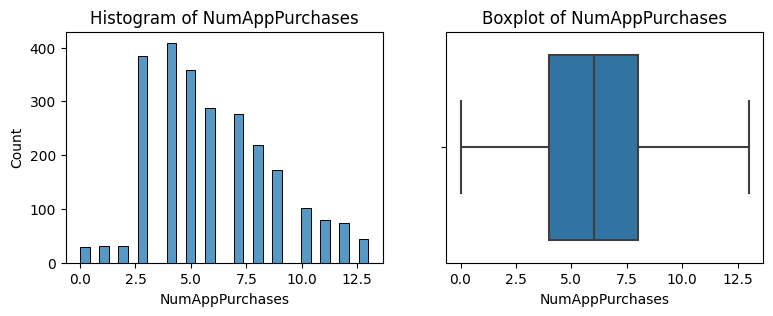

Skew: 0.5352427343804749, Kurtosis : -0.2154201568874261


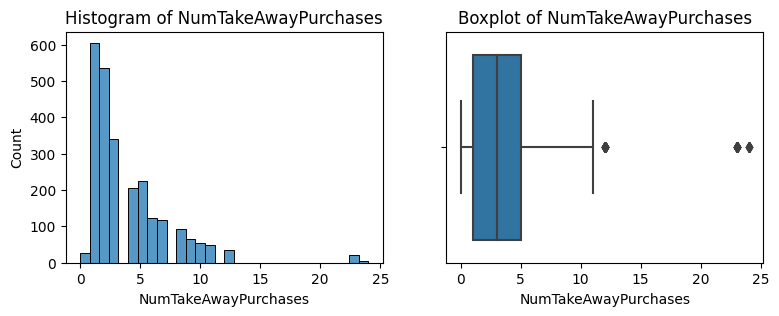

Skew: 2.3900164618425097, Kurtosis : 9.14690092475826


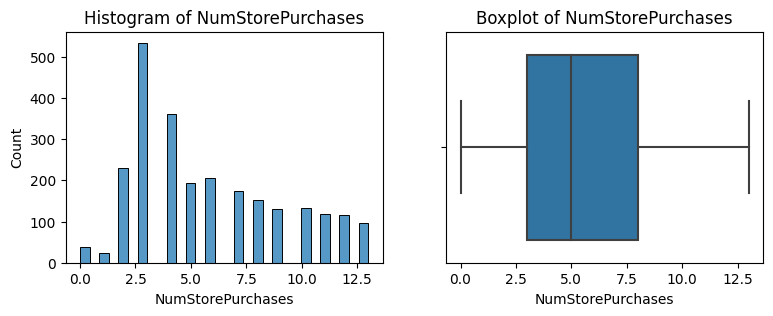

Skew: 0.6119897083696106, Kurtosis : -0.7240328472444681


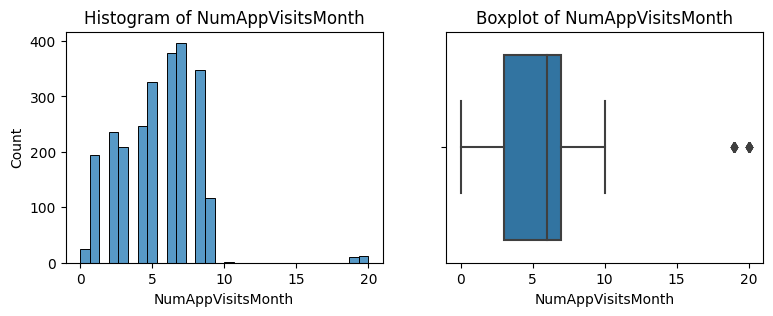

Skew: 0.9706319237195967, Kurtosis : 4.989026719884712


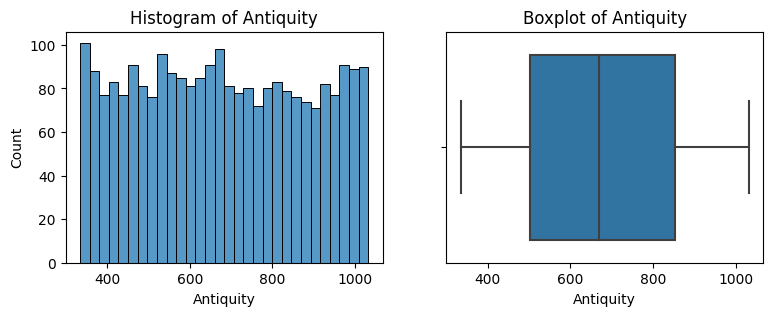

Skew: 0.0427689679463382, Kurtosis : -1.1915784398953502


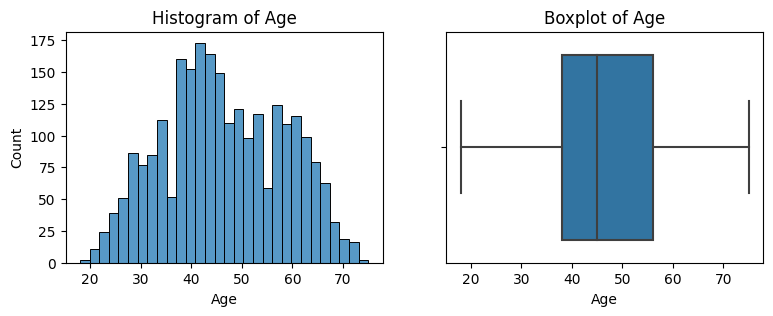

Skew: 0.06304240758491092, Kurtosis : -0.8168653337922467


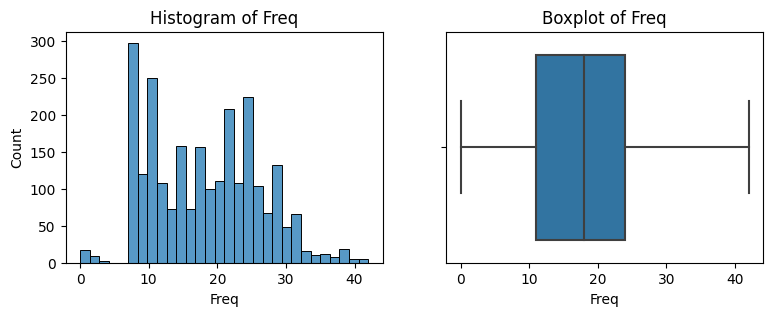

Skew: 0.22520269262336717, Kurtosis : -0.7142312507954243


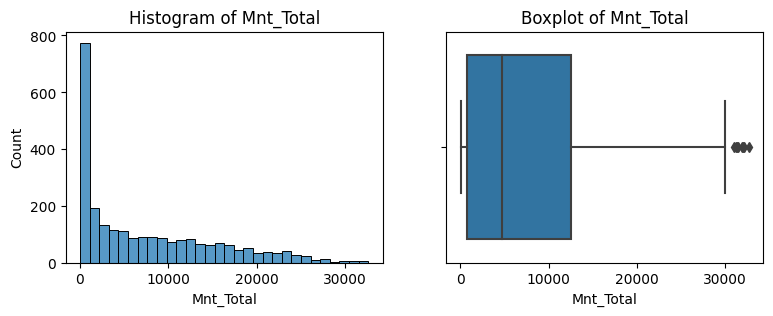

Skew: 0.9429060100563523, Kurtosis : -0.1328564214356307


In [245]:
for var in numeric:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    sns.histplot(ax=ax1, x=numeric[var], bins=30)
    sns.boxplot(ax=ax2, x=numeric[var])
    ax1.set_title(f"Histogram of {var}")
    ax2.set_title(f"Boxplot of {var}")
    plt.show()
    print(f'Skew: {numeric[var].skew()}, Kurtosis : {numeric[var].kurt()}')


In [ ]:
import numpy as np
from scipy import stats

total=0
for i in numeric:
    # Generate a sample dataset
    data = numeric[i]

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(data))

    # Define a threshold for outlier detection
    threshold = 4  # Adjust this value based on your requirements

    # Identify outliers
    outliers = np.where(z_scores > threshold)[0]
    total += len(outliers)



    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers')
print(total)

Income has 31 outliers
MntEntries has 17 outliers
MntVegan&Vegetarian has 25 outliers
MntDesserts has 12 outliers
MntAdditionalRequests has 11 outliers
NumOfferPurchases has 38 outliers
NumTakeAwayPurchases has 26 outliers
NumAppVisitsMonth has 22 outliers
182


2500

### Conclusions
- 18 duplicated rows - drop them 
- Nan's (Education - 33, Recency - 48, MntDrinks - 21)

- Categorical - 12 vars
    - Education - Try to reduce number of categories
    - Marital Status - Solve casing issues - Try to reduce number of categories
    - Response Campaign - Try to group in a single var (Number of campaigns responded) or maybe find a cutoff point
    - Kids- Try binary var(have or don't have)
    - Complain - low variability - Try drop
    - Target- DepVar - highly unbalanced set
    - Gender - highly unbalanced set
<br></br>
- Numeric
    - Incongruence in Freq (some has 0 but spent money) - set to 1 low values and remove two cases with high amount spent
    - Cost Contact and Revenue are constant - drop them
    - Outliers - try with and without
    - Distributions - apply transformation to help normalize 
    - Scaling - standardize 


Next Steps:
- Search statistical tests to detect outliers

- Cross Validation:
    - K-Fold Cross-Validation
    - Stratified K-Fold Cross-Validation
    - Leave-One-Out Cross-Validation (LOOCV)
    -Study/Search for methods for unbalanced sets

- Feature Selection
    - Categorical:
        - chi-square
        - Check others
    - Numerical:
        - __(1) Variance__ - To  understand if there are any constant variables;<br>
        - __(2) Spearman Correlation__ - To verify if there are any correlated features;<br>
        - __(3) Decision Trees__ - To just keep one variable from a group of correlated features;<br>
        - __(4) RFE__ - To iteratively select features by considering subsets of features;<br>
        - __(5) Lasso__ - To identify and select important features in a dataset;<br>
